# Extracting Topics and Entities from Bio-Medical Text 

## Gather Bio-Medical Data

In [1]:
!gdown --id 1qM-W9poYlsVB1ko6V7iskttrM03kj1xq

Downloading...
From: https://drive.google.com/uc?id=1qM-W9poYlsVB1ko6V7iskttrM03kj1xq
To: /content/BioASQ_data.zip
100% 4.52M/4.52M [00:00<00:00, 71.2MB/s]


In [2]:
!unzip "/content/BioASQ_data.zip" -d "/content/"

Archive:  /content/BioASQ_data.zip
replace /content/BioASQ_data/BioASQ-test-factoid-4b-1.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/BioASQ_data/BioASQ-test-factoid-4b-1.json  
replace /content/BioASQ_data/BioASQ-test-factoid-4b-2.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/BioASQ_data/BioASQ-test-factoid-4b-2.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/BioASQ_data/BioASQ-test-factoid-4b-2.json  
  inflating: /content/BioASQ_data/BioASQ-test-factoid-4b-3.json  
  inflating: /content/BioASQ_data/BioASQ-test-factoid-4b-4.json  
  inflating: /content/BioASQ_data/BioASQ-test-factoid-4b-5.json  
  inflating: /content/BioASQ_data/BioASQ-test-factoid-5b-1.json  
  inflating: /content/BioASQ_data/BioASQ-test-factoid-5b-2.json  
  inflating: /content/BioASQ_data/BioASQ-test-factoid-5b-3.json  
  inflating: /content/BioASQ_data/BioASQ-test-factoid-5b-4.json  
  inflating: /content/BioASQ_data/BioASQ-t

## Install Relevant Dependencies

In [3]:
!pip install --quiet spacy==3.2.1
!pip install --quiet bertopic==0.9.4
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 15.7 MB 5.2 MB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 3.4 MB 45.3 MB/s 
     |████████████████████████████████| 6.8 MB 17.7 MB/s 
     |████████████████████████████████| 1.2 MB 45.2 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 895 kB 48.9 MB/s 
     |████████████████████████████████| 636 kB 27.2 MB/s 
     |████████████████████████████████| 3.3 MB 37.0 MB/s 
     |████████████████████████████████| 1.1 MB 46.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have nu

In [5]:
!pip install --quiet numpy==1.21.5

## Training BERT Topic Model on Bio-Medical Data 

In [6]:
from glob import glob
from tqdm import tqdm
import json
from collections import OrderedDict
from bertopic import BERTopic
import warnings
import spacy
import os
from nltk.corpus import stopwords
import nltk

warnings.filterwarnings("ignore", category=DeprecationWarning)

nltk.download('stopwords')
# CONSTANT VARIABLES
TOPIC_MODEL_BY_CLUSTER__NAME = 'bioBERTopic_model'
TOPIC_MODEL_BY_CLUSTER__PATH = '/content/resources/topicByClusterModel'


class TopicsByCluster:
    def __init__(self, bio_asq_path):
        self.bio_asq_path = bio_asq_path
        self.bio_docs = None

    def get_documents(self):
        documents = []
        if os.path.isdir(self.bio_asq_path):
            json_files = glob(self.bio_asq_path + "/*")
        else:
            assert False, "The path does not exist"
        for json_file in tqdm(json_files):
            with open(json_file) as file:
                asq_content = json.loads(file.read())
                documents.append(asq_content)

        self.bio_docs = []
        for doc in documents:
            for i in tqdm(range(len(doc['data'][0]['paragraphs']))):
                self.bio_docs.append(doc['data'][0]['paragraphs'][i]['context'])

        self.bio_docs = list(OrderedDict.fromkeys(self.bio_docs))

        return self.bio_docs

    def preprocess_doc(self,bio_docs):
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        stop_words = stopwords.words('english')
        text_out = []
        for text in tqdm(bio_docs):
            doc = nlp(text)
            new_text = []
            for token in doc:
                if (token.pos_ in ['NOUN', 'ADJ']) and (str(token) not in stop_words):
                    new_text.append(token.lemma_)
            final = " ".join(new_text)
            text_out.append(final)
        return text_out

    def trainBERTopicTransformerModel(self, topic_model_save_path, topic_model_save_name):

        topic_spacy_model = BERTopic(n_gram_range=(1, 3), language="english")
        print("Pre-Processing Medical Text..")

        bio_docs = self.preprocess_doc(self.get_documents())
        print("Pre-Processing Done!")

        print("Training BERT Transformer Model to find topics...")
        topics, probs = topic_spacy_model.fit_transform(bio_docs)
        print("Training completed!")

        if not os.path.isdir(topic_model_save_path):
            os.mkdir(topic_model_save_path)
        model_save_path = topic_model_save_path + "/" + topic_model_save_name
        print("Saving the model to : {}".format(model_save_path))
        topic_spacy_model.save(model_save_path)
        print("Model saved!")

        return topic_spacy_model


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
topic_by_cluster = TopicsByCluster(bio_asq_path='/content/BioASQ_data')

In [8]:
if not os.path.isdir(TOPIC_MODEL_BY_CLUSTER__PATH):
  os.makedirs(TOPIC_MODEL_BY_CLUSTER__PATH)
  topic_model = topic_by_cluster.trainBERTopicTransformerModel(
  topic_model_save_path=TOPIC_MODEL_BY_CLUSTER__PATH,
  topic_model_save_name=TOPIC_MODEL_BY_CLUSTER__NAME)
else:
  print("Loading Saved Model")
  topic_model = BERTopic.load(TOPIC_MODEL_BY_CLUSTER__PATH + "/" + TOPIC_MODEL_BY_CLUSTER__NAME)

Pre-Processing Medical Text..


100%|██████████| 3777/3777 [01:18<00:00, 48.32it/s]


Pre-Processing Done!
Training BERT Transformer Model to find topics...


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Training completed!
Saving the model to : /content/resources/topicByClusterModel/bioBERTopic_model
Model saved!


## Visualizing Topics from BERT Topic model

In [9]:
topic_model.visualize_topics()

In [10]:
topic_model.visualize_hierarchy(top_n_topics=20)

In [11]:
topic_model.visualize_barchart(top_n_topics=10)

## Extracting Disease and Genetic Entities

### Get Original Bio-Medical Documents

In [12]:
doc_paths = glob('/content/BioASQ_data/*')

In [13]:
doc_paths

['/content/BioASQ_data/BioASQ-test-factoid-4b-2.json',
 '/content/BioASQ_data/BioASQ-test-factoid-5b-4.json',
 '/content/BioASQ_data/BioASQ-test-factoid-6b-5.json',
 '/content/BioASQ_data/BioASQ-test-factoid-5b-2.json',
 '/content/BioASQ_data/BioASQ-test-factoid-6b-1.json',
 '/content/BioASQ_data/BioASQ-train-factoid-5b.json',
 '/content/BioASQ_data/BioASQ-test-factoid-5b-5.json',
 '/content/BioASQ_data/BioASQ-test-factoid-6b-2.json',
 '/content/BioASQ_data/BioASQ-train-factoid-6b.json',
 '/content/BioASQ_data/BioASQ-test-factoid-4b-1.json',
 '/content/BioASQ_data/BioASQ-test-factoid-5b-3.json',
 '/content/BioASQ_data/BioASQ-test-factoid-4b-3.json',
 '/content/BioASQ_data/BioASQ-test-factoid-5b-1.json',
 '/content/BioASQ_data/BioASQ-test-factoid-6b-3.json',
 '/content/BioASQ_data/BioASQ-test-factoid-6b-4.json',
 '/content/BioASQ_data/BioASQ-test-factoid-4b-5.json',
 '/content/BioASQ_data/BioASQ-train-factoid-4b.json',
 '/content/BioASQ_data/BioASQ-test-factoid-4b-4.json']

In [14]:
def get_documents(doc_paths):
    documents = []
    for doc in tqdm(doc_paths):
        with open(doc) as file:
            json_doc = json.loads(file.read())
            documents.append(json_doc)

    return documents

In [15]:
json_document_content = get_documents(doc_paths)

100%|██████████| 18/18 [00:00<00:00, 125.44it/s]


In [16]:
bio_docs = []
for doc in json_document_content:
    for i in tqdm(range(len(doc['data'][0]['paragraphs']))):
        bio_docs.append(doc['data'][0]['paragraphs'][i]['context'])

100%|██████████| 116/116 [00:00<00:00, 431711.86it/s]


In [17]:
bio_docs = list(OrderedDict.fromkeys(bio_docs))

### Extracting Disease Entities (Using GPU)

In [18]:
!pip install --quiet transformers

In [19]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("bioformers/bioformer-cased-v1.0-ncbi-disease")
model = AutoModelForTokenClassification.from_pretrained("bioformers/bioformer-cased-v1.0-ncbi-disease")

Downloading:   0%|          | 0.00/119 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/611 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/162M [00:00<?, ?B/s]

In [20]:
def get_disease_entities(doc):

  disease_entities = []

  #initiate NER transformer pipeline
  ner_pipe = pipeline("ner", model=model, tokenizer=tokenizer,device=0)
  entities = []

  # Get all the entities separatly for 'B-bio' and 'I-bio'
  for i, entity in enumerate(ner_pipe(doc)):
    entities.append(entity)

  # Combine the entities starting with 'B-bio' and ending with 'I-bio'
  grouped = []
  for i, entity in enumerate(entities):
    start_indx = i
    if entity['entity']=='B-bio':
      try:
        j=0
        while (entities[start_indx+1]['entity']!='B-bio') and (start_indx+1<len(entities)-1):
          j=j+1
          start_indx = start_indx+1
      
        if len(entities[i:i+1+j+1])!=0:
          #print(entities[i:i+1+j+1])
          grouped.append(entities[i:i+1+j+1])
      except:
        grouped.append([entities[-1]])

  # Extract the word from document for the disease
  if len(grouped[-1])==1:
    for grouped_entity in grouped[:-1]:
      #print(grouped_entity[0],grouped_entity[-2])
      start_index = grouped_entity[0]['start']
      end_index = grouped_entity[-2]['end']
      #print(doc[start_index:end_index])
      disease_entities.append(doc[start_index:end_index])
    #print(doc[grouped[-1][0]['start']:grouped[-1][0]['end']])
    disease_entities.append(doc[grouped[-1][0]['start']:grouped[-1][0]['end']])
  else:
    for grouped_entity in grouped[:-1]:
      start_index = grouped_entity[0]['start']
      end_index = grouped_entity[-2]['end']
      #print(doc[start_index:end_index])
      disease_entities.append(doc[start_index:end_index])
    last_start_index = grouped[-1][0]['start']
    last_end_index = grouped[-1][-1]['end']
    #print(doc[last_start_index:last_end_index])
    disease_entities.append(doc[last_start_index:last_end_index])

  return disease_entities

In [21]:
disease_entities = []
for doc in tqdm(bio_docs):
  try:
    disease_entities = disease_entities + get_disease_entities(doc)
  except:
    continue

100%|██████████| 3777/3777 [03:21<00:00, 18.71it/s]


In [22]:
disease_entities = list(OrderedDict.fromkeys(disease_entities))

In [23]:
textfile = open("DiseasesNER.txt", "w")

for entity in disease_entities:

    textfile.write(entity + "\n")

textfile.close()

### Extracting Genetic Entities (using GPU)

In [24]:
tokenizer = AutoTokenizer.from_pretrained("alvaroalon2/biobert_genetic_ner")
model = AutoModelForTokenClassification.from_pretrained("alvaroalon2/biobert_genetic_ner")

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/746 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411M [00:00<?, ?B/s]

In [25]:
def get_genetic_entities(doc):

  genetic_entities = []

  #initiate NER transformer pipeline
  ner_pipe = pipeline("ner", model=model, tokenizer=tokenizer, device=0)
  entities = []

  # Get all the entities separatly for 'B-bio' and 'I-bio'
  for i, entity in enumerate(ner_pipe(doc)):
    entities.append(entity)

  # Combine the entities starting with 'B-bio' and ending with 'I-bio'
  grouped = []
  for i, entity in enumerate(entities):
    start_indx = i
    if entity['entity']=='B-GENETIC':
      try:
        j=0
        while (entities[start_indx+1]['entity']!='B-GENETIC') and (start_indx+1<len(entities)-1):
          j=j+1
          start_indx = start_indx+1
      
        if len(entities[i:i+1+j+1])!=0:
          #print(entities[i:i+1+j+1])
          grouped.append(entities[i:i+1+j+1])
      except:
        grouped.append([entities[-1]])

  # Extract the word from document for the disease
  if len(grouped[-1])==1:
    for grouped_entity in grouped[:-1]:
      #print(grouped_entity[0],grouped_entity[-2])
      start_index = grouped_entity[0]['start']
      end_index = grouped_entity[-2]['end']
      #print(doc[start_index:end_index])
      genetic_entities.append(doc[start_index:end_index])
    #print(doc[grouped[-1][0]['start']:grouped[-1][0]['end']])
    genetic_entities.append(doc[grouped[-1][0]['start']:grouped[-1][0]['end']])
  else:
    for grouped_entity in grouped[:-1]:
      start_index = grouped_entity[0]['start']
      end_index = grouped_entity[-2]['end']
      #print(doc[start_index:end_index])
      genetic_entities.append(doc[start_index:end_index])
    last_start_index = grouped[-1][0]['start']
    last_end_index = grouped[-1][-1]['end']
    #print(doc[last_start_index:last_end_index])
    genetic_entities.append(doc[last_start_index:last_end_index])

  return genetic_entities

In [26]:
genetic_entities = []
for doc in tqdm(bio_docs):
  try:
    genetic_entities = genetic_entities + get_genetic_entities(doc)
  except:
    continue

100%|██████████| 3777/3777 [06:01<00:00, 10.46it/s]


In [27]:
textfile = open("geneticsNER.txt", "w")

for entity in genetic_entities:

    textfile.write(entity + "\n")

textfile.close()

## EXTRA: Topic Modelling using LDA

In [29]:
!pip install --quiet --upgrade gensim
!pip install --quiet --upgrade pyldavis
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 1.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [30]:
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore', 'SelectableGroups dict interface')
import glob
import json
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict
import re
import spacy
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
from nltk import FreqDist

%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



True

In [31]:
assert len(bio_docs) == len(list(set(bio_docs)))

In [32]:
stop_words = stopwords.words('english')

In [33]:
def lemmatize(texts):
  nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])
  text_out = []
  for text in tqdm(texts):
    doc = nlp(text)
    new_text = []
    for token in doc:
      #if (token.pos_ in ['NOUN','ADJ','VERB','ADV']):
      if (token.pos_ in ['NOUN','ADJ']) and (str(token) not in stop_words):
        new_text.append(token.lemma_)
    final = " ".join(new_text)
    text_out.append(final)
  return text_out

In [34]:
bio_docs = lemmatize(bio_docs)

100%|██████████| 3777/3777 [01:16<00:00, 49.07it/s]


In [35]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,10))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  ax.set_xticklabels(
    labels=fdist.keys(), rotation=90)
  plt.show()

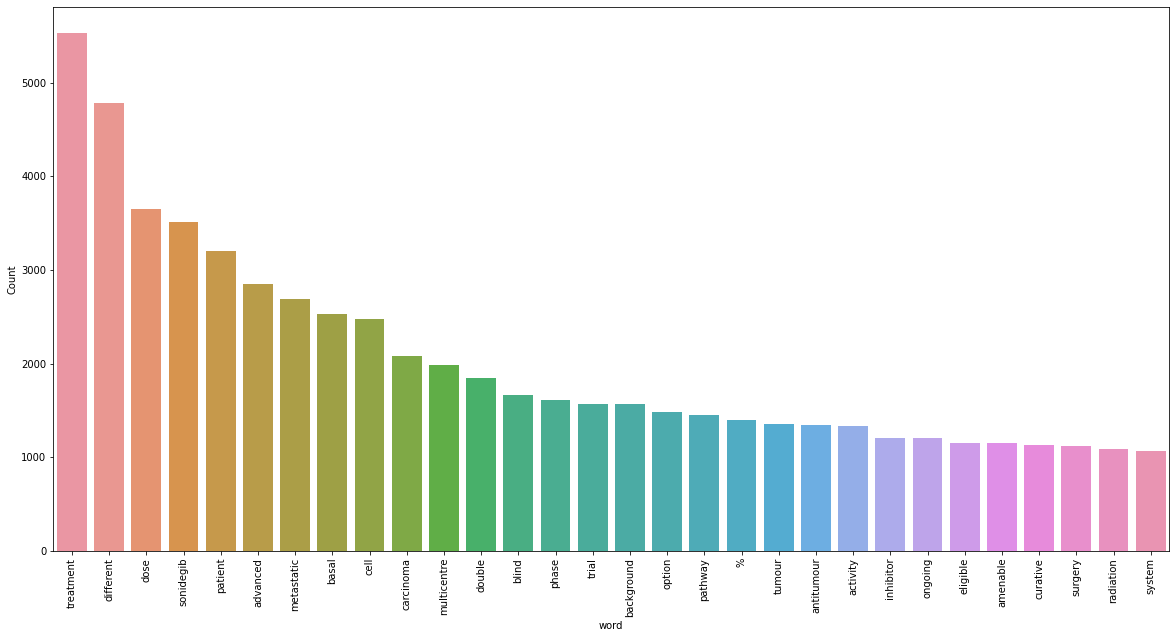

In [37]:
freq_words(bio_docs)

In [38]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text)
        final.append(new)
    return (final)

In [40]:
data_words = gen_words(bio_docs)

In [41]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

In [42]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           iterations=300,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto",
                                           eta="auto",
                                           eval_every=None)

In [47]:
lda_model.show_topics()

[(0,
  '0.014*"type" + 0.013*"study" + 0.012*"control" + 0.011*"result" + 0.011*"analysis" + 0.010*"high" + 0.009*"phenotype" + 0.009*"method" + 0.009*"low" + 0.007*"individual"'),
 (1,
  '0.052*"chromosome" + 0.034*"cycle" + 0.031*"origin" + 0.031*"replication" + 0.020*"recombinant" + 0.015*"dna" + 0.014*"instability" + 0.013*"consequence" + 0.012*"benign" + 0.011*"package"'),
 (2,
  '0.052*"enzyme" + 0.026*"stress" + 0.022*"thyroid" + 0.021*"injury" + 0.020*"repair" + 0.019*"culture" + 0.017*"transporter" + 0.016*"lack" + 0.016*"renal" + 0.016*"carcinoma"'),
 (3,
  '0.052*"patient" + 0.024*"treatment" + 0.018*"group" + 0.017*"clinical" + 0.014*"study" + 0.012*"disease" + 0.012*"therapy" + 0.011*"trial" + 0.010*"risk" + 0.009*"drug"'),
 (4,
  '0.042*"protein" + 0.032*"gene" + 0.016*"human" + 0.012*"function" + 0.012*"complex" + 0.012*"domain" + 0.012*"sequence" + 0.009*"region" + 0.009*"site" + 0.009*"structure"'),
 (5,
  '0.074*"mutation" + 0.051*"patient" + 0.050*"syndrome" + 0.034*